# Assignment 07

## Load Model

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import math

In [2]:
class Linear(nn.Module):

    def __init__(self, num_classes=2, init_weights=True):

        super(Linear, self).__init__()

        self.number_class   = num_classes

        _size_image     = 100* 100
        _num1           = 10
        _num2           = 5
        
        self.fc1        = nn.Linear(_size_image, _num1, bias=True)
        self.fc2        = nn.Linear(_num1, _num2, bias=True)
        self.fc3        = nn.Linear(_num2, num_classes, bias=True)

        self.fc_layer1  = nn.Sequential(self.fc1, nn.ReLU(True))
        self.fc_layer2  = nn.Sequential(self.fc2, nn.ReLU(True))
        self.fc_layer3  = nn.Sequential(self.fc3, nn.ReLU(True))
        
        self.classifier = nn.Sequential(self.fc_layer1, self.fc_layer2, self.fc_layer3)
        
        if(init_weights):
            self._initialize_weight()        
        
    def _initialize_weight(self):
        
        for m in self.modules():
            if isinstance (m, nn.Linear):
                n = m.in_features
                m.weight.data.uniform_(- 1.0 / math.sqrt(n), 1.0 / math.sqrt(n))

                if m.bias is not None:

                    m.bias.data.zero_()

    def forward(self, x):

        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

## Load Dataset

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

torch.__version__

'1.2.0'

In [4]:
transform = transforms.Compose([#transforms.Resize((1,10000)),
                                transforms.Grayscale(),		# the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
                                transforms.ToTensor(),])


#train_data_path = 'relative path of training data set'
train_data_path = '..\\Assignment#2\\horse-or-human\\train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
# if shuffle=True, the data reshuffled at every epoch 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=1)  


validation_data_path = '..\\Assignment#2\\horse-or-human\\validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
valloader = torch.utils.data.DataLoader(valset, batch_size=256, shuffle=False, num_workers=1)

In [ ]:
# print(len(valloader))
# print(len(trainloader))
# print(trainloader.batch_size)

for idx_batch, (data, target) in enumerate(trainloader):
    print(idx_batch)
    print(data.shape)
    print(target.shape)
    print(len(data))
    print("__________________")
    print()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 이미지를 보여주기 위한 함수


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(labels)
print(images.shape)
# print(images)

# Training

In [5]:
# -----------------------------------------------------------------------------
# import packages
# -----------------------------------------------------------------------------
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import argparse
import sys
import os
import numpy as np
import time
import datetime 
import csv
import configparser
import argparse
import platform
from tqdm.notebook import trange, tqdm

from torchvision import datasets, transforms
from torch.autograd import Variable
from random import shuffle



# -----------------------------------------------------------------------------
# load neural network model
# -----------------------------------------------------------------------------

num_classes = 2
model = Linear(num_classes=num_classes)

# -----------------------------------------------------------------------------
# Set the flag for using cuda
# -----------------------------------------------------------------------------

bCuda = 1

if bCuda:
    model.cuda()

# -----------------------------------------------------------------------------
# optimization algorithm
# -----------------------------------------------------------------------------

optimizer   = optim.SGD(model.parameters(), lr=0.001)
objective   = nn.CrossEntropyLoss()

# -----------------------------------------------------------------------------
# function for training the model
# -----------------------------------------------------------------------------

def train():

    loss_train     = []
    accuracy_train = []
    pre_batch_size = 0
    
    model.train()
#     print("_____________")
    
    for idx_batch, (data, target) in enumerate(trainloader):
        
        if len(data) < pre_batch_size:
            continue
        pre_batch_size = len(data)
        
        correct = 0
        
        if bCuda:
            data, target    = data.cuda(), target.cuda()

        data, target    = Variable(data), Variable(target)

        optimizer.zero_grad()
        output = model(data)
        
        pred    = output.data.max(1)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        accuracy_test   = 100. * float(correct) / trainloader.batch_size
        accuracy_train.append(accuracy_test)
        
        loss = objective(output, target)
#         print("LOSS : %s" % loss)
        loss.backward()
        optimizer.step()

        loss_train_batch = loss.item()
        loss_train.append(loss_train_batch)
    
    
    loss_train_mean = np.mean(loss_train)
    loss_train_std  = np.std(loss_train)
    accuracy_train_mean = np.mean(accuracy_train)
    
#     print("=============")
#     print(accuracy_train)
    return {'loss_train_mean': loss_train_mean, 'loss_train_std': loss_train_std, 'accuracy_train': accuracy_train_mean}

# -----------------------------------------------------------------------------
# function for testing the model
# -----------------------------------------------------------------------------

def test():

    # print('test the model at given epoch')

    accuracy_test   = []
    loss_test       = 0
    correct         = 0

    model.eval()

    for idx_batch, (data, target) in enumerate(valloader):

        if bCuda:       
            data, target    = data.cuda(), target.cuda()
        data, target    = Variable(data), Variable(target)

        output  = model(data)
        loss    = objective(output, target)

        loss_test   += loss.item()
        pred        = output.data.max(1)[1]
        correct     += pred.eq(target.data.view_as(pred)).cpu().sum()

    loss_test       = loss_test
    accuracy_test   = 100. * float(correct) / len(valloader.dataset)

    return {'loss_test': loss_test, 'accuracy_test': accuracy_test}

In [9]:
# -----------------------------------------------------------------------------
# iteration for the epoch
# -----------------------------------------------------------------------------
epoch = 1000

loss_train_mean = []
loss_train_std = []
loss_test = []
accuracy_test = []
accuracy_train = []


for e in trange(epoch):
    
    result_train    = train()
    result_test     = test()

    loss_train_mean.append(result_train['loss_train_mean'])
    loss_train_std.append(result_train['loss_train_std'])
    loss_test.append(result_test['loss_test'])

    accuracy_train.append(result_train['accuracy_train'])
    accuracy_test.append(result_test['accuracy_test'])
    
#     if e+1 % 100 == 0 : 
    print("[epoch %5d] loss: (training) %0.5f, (testing) %0.5f, accuracy: (training) %0.5f, (testing) %0.5f" % (e+1, result_train['loss_train_mean'], result_test['loss_test'],result_train['accuracy_train'], result_test['accuracy_test']))

[epoch     1] loss: (training) 0.44166, (testing) 0.53824, accuracy: (training) 87.98828, (testing) 88.28125
[epoch     2] loss: (training) 0.44048, (testing) 0.53811, accuracy: (training) 88.28125, (testing) 88.28125
[epoch     3] loss: (training) 0.43965, (testing) 0.53771, accuracy: (training) 88.47656, (testing) 88.28125
[epoch     4] loss: (training) 0.44058, (testing) 0.53804, accuracy: (training) 88.37891, (testing) 88.28125
[epoch     5] loss: (training) 0.44068, (testing) 0.54214, accuracy: (training) 88.67188, (testing) 87.10938
[epoch     6] loss: (training) 0.43975, (testing) 0.54036, accuracy: (training) 88.18359, (testing) 87.50000
[epoch     7] loss: (training) 0.44194, (testing) 0.54121, accuracy: (training) 88.57422, (testing) 87.10938
[epoch     8] loss: (training) 0.43982, (testing) 0.54667, accuracy: (training) 88.47656, (testing) 86.71875
[epoch     9] loss: (training) 0.43878, (testing) 0.53969, accuracy: (training) 87.79297, (testing) 87.50000
[epoch    10] loss:

[epoch    76] loss: (training) 0.42997, (testing) 0.54039, accuracy: (training) 88.76953, (testing) 87.10938
[epoch    77] loss: (training) 0.42894, (testing) 0.55088, accuracy: (training) 89.94141, (testing) 87.10938
[epoch    78] loss: (training) 0.42916, (testing) 0.55218, accuracy: (training) 89.45312, (testing) 87.10938
[epoch    79] loss: (training) 0.42967, (testing) 0.54410, accuracy: (training) 88.76953, (testing) 87.10938
[epoch    80] loss: (training) 0.42919, (testing) 0.54478, accuracy: (training) 89.35547, (testing) 87.10938
[epoch    81] loss: (training) 0.42787, (testing) 0.54124, accuracy: (training) 88.96484, (testing) 87.50000
[epoch    82] loss: (training) 0.42768, (testing) 0.54574, accuracy: (training) 89.74609, (testing) 87.10938
[epoch    83] loss: (training) 0.42789, (testing) 0.54669, accuracy: (training) 89.55078, (testing) 87.10938
[epoch    84] loss: (training) 0.42862, (testing) 0.54568, accuracy: (training) 89.35547, (testing) 87.10938
[epoch    85] loss:

[epoch   151] loss: (training) 0.41786, (testing) 0.55665, accuracy: (training) 89.84375, (testing) 87.10938
[epoch   152] loss: (training) 0.41714, (testing) 0.55145, accuracy: (training) 89.35547, (testing) 86.71875
[epoch   153] loss: (training) 0.41630, (testing) 0.55457, accuracy: (training) 90.23438, (testing) 87.10938
[epoch   154] loss: (training) 0.41645, (testing) 0.55173, accuracy: (training) 89.84375, (testing) 86.71875
[epoch   155] loss: (training) 0.41550, (testing) 0.55929, accuracy: (training) 90.62500, (testing) 87.10938
[epoch   156] loss: (training) 0.41660, (testing) 0.54766, accuracy: (training) 89.45312, (testing) 86.32812
[epoch   157] loss: (training) 0.41622, (testing) 0.55343, accuracy: (training) 90.52734, (testing) 87.10938
[epoch   158] loss: (training) 0.41641, (testing) 0.55345, accuracy: (training) 90.33203, (testing) 87.10938
[epoch   159] loss: (training) 0.41580, (testing) 0.55082, accuracy: (training) 89.84375, (testing) 86.71875
[epoch   160] loss:

[epoch   226] loss: (training) 0.34098, (testing) 0.35666, accuracy: (training) 91.79688, (testing) 87.10938
[epoch   227] loss: (training) 0.33364, (testing) 0.35865, accuracy: (training) 92.08984, (testing) 84.37500
[epoch   228] loss: (training) 0.32991, (testing) 0.34824, accuracy: (training) 92.48047, (testing) 86.32812
[epoch   229] loss: (training) 0.32527, (testing) 0.34496, accuracy: (training) 92.48047, (testing) 86.32812
[epoch   230] loss: (training) 0.32210, (testing) 0.35914, accuracy: (training) 92.28516, (testing) 83.98438
[epoch   231] loss: (training) 0.31861, (testing) 0.33863, accuracy: (training) 92.77344, (testing) 86.32812
[epoch   232] loss: (training) 0.31474, (testing) 0.34729, accuracy: (training) 92.67578, (testing) 83.98438
[epoch   233] loss: (training) 0.31226, (testing) 0.33482, accuracy: (training) 92.67578, (testing) 86.71875
[epoch   234] loss: (training) 0.30963, (testing) 0.33783, accuracy: (training) 92.87109, (testing) 85.54688
[epoch   235] loss:

[epoch   301] loss: (training) 0.24243, (testing) 0.35237, accuracy: (training) 93.84766, (testing) 84.37500
[epoch   302] loss: (training) 0.24167, (testing) 0.34540, accuracy: (training) 93.84766, (testing) 83.59375
[epoch   303] loss: (training) 0.24166, (testing) 0.36946, accuracy: (training) 93.94531, (testing) 82.03125
[epoch   304] loss: (training) 0.24172, (testing) 0.35705, accuracy: (training) 93.65234, (testing) 84.37500
[epoch   305] loss: (training) 0.24088, (testing) 0.33574, accuracy: (training) 93.94531, (testing) 85.15625
[epoch   306] loss: (training) 0.24010, (testing) 0.35660, accuracy: (training) 93.94531, (testing) 84.76562
[epoch   307] loss: (training) 0.23935, (testing) 0.36340, accuracy: (training) 94.14062, (testing) 83.20312
[epoch   308] loss: (training) 0.23876, (testing) 0.34814, accuracy: (training) 93.94531, (testing) 83.59375
[epoch   309] loss: (training) 0.23809, (testing) 0.34675, accuracy: (training) 94.23828, (testing) 83.59375
[epoch   310] loss:

[epoch   376] loss: (training) 0.19999, (testing) 0.38345, accuracy: (training) 95.41016, (testing) 82.81250
[epoch   377] loss: (training) 0.19737, (testing) 0.38971, accuracy: (training) 95.80078, (testing) 81.64062
[epoch   378] loss: (training) 0.19798, (testing) 0.39308, accuracy: (training) 95.70312, (testing) 82.03125
[epoch   379] loss: (training) 0.19789, (testing) 0.40631, accuracy: (training) 95.21484, (testing) 81.25000
[epoch   380] loss: (training) 0.19733, (testing) 0.38732, accuracy: (training) 95.31250, (testing) 82.03125
[epoch   381] loss: (training) 0.19803, (testing) 0.38168, accuracy: (training) 95.50781, (testing) 83.59375
[epoch   382] loss: (training) 0.19673, (testing) 0.40538, accuracy: (training) 95.21484, (testing) 81.25000
[epoch   383] loss: (training) 0.19589, (testing) 0.39043, accuracy: (training) 95.60547, (testing) 81.64062
[epoch   384] loss: (training) 0.19526, (testing) 0.40592, accuracy: (training) 95.31250, (testing) 81.25000
[epoch   385] loss:

[epoch   451] loss: (training) 0.16557, (testing) 0.41484, accuracy: (training) 96.38672, (testing) 81.64062
[epoch   452] loss: (training) 0.16606, (testing) 0.46168, accuracy: (training) 96.48438, (testing) 79.68750
[epoch   453] loss: (training) 0.16682, (testing) 0.42277, accuracy: (training) 96.19141, (testing) 80.46875
[epoch   454] loss: (training) 0.16593, (testing) 0.42125, accuracy: (training) 96.38672, (testing) 80.85938
[epoch   455] loss: (training) 0.16430, (testing) 0.47359, accuracy: (training) 96.58203, (testing) 79.68750
[epoch   456] loss: (training) 0.16601, (testing) 0.46547, accuracy: (training) 96.58203, (testing) 79.68750
[epoch   457] loss: (training) 0.16325, (testing) 0.41344, accuracy: (training) 96.77734, (testing) 81.25000
[epoch   458] loss: (training) 0.16343, (testing) 0.42551, accuracy: (training) 96.97266, (testing) 80.46875
[epoch   459] loss: (training) 0.16190, (testing) 0.42920, accuracy: (training) 96.48438, (testing) 80.46875
[epoch   460] loss:

[epoch   526] loss: (training) 0.13997, (testing) 0.45126, accuracy: (training) 97.16797, (testing) 80.85938
[epoch   527] loss: (training) 0.13986, (testing) 0.45476, accuracy: (training) 97.46094, (testing) 80.46875
[epoch   528] loss: (training) 0.13920, (testing) 0.46978, accuracy: (training) 97.55859, (testing) 79.68750
[epoch   529] loss: (training) 0.13878, (testing) 0.46171, accuracy: (training) 97.55859, (testing) 79.29688
[epoch   530] loss: (training) 0.13896, (testing) 0.44872, accuracy: (training) 97.26562, (testing) 80.46875
[epoch   531] loss: (training) 0.13995, (testing) 0.50433, accuracy: (training) 97.26562, (testing) 78.90625
[epoch   532] loss: (training) 0.13816, (testing) 0.45423, accuracy: (training) 97.36328, (testing) 80.46875
[epoch   533] loss: (training) 0.13790, (testing) 0.46319, accuracy: (training) 97.26562, (testing) 79.29688
[epoch   534] loss: (training) 0.13827, (testing) 0.47531, accuracy: (training) 97.26562, (testing) 79.68750
[epoch   535] loss:

[epoch   601] loss: (training) 0.11994, (testing) 0.48872, accuracy: (training) 97.36328, (testing) 78.90625
[epoch   602] loss: (training) 0.11916, (testing) 0.48716, accuracy: (training) 97.55859, (testing) 79.29688
[epoch   603] loss: (training) 0.11910, (testing) 0.54106, accuracy: (training) 97.65625, (testing) 78.90625
[epoch   604] loss: (training) 0.11848, (testing) 0.49192, accuracy: (training) 97.55859, (testing) 78.90625
[epoch   605] loss: (training) 0.11837, (testing) 0.49865, accuracy: (training) 97.75391, (testing) 79.68750
[epoch   606] loss: (training) 0.11773, (testing) 0.49427, accuracy: (training) 97.65625, (testing) 78.90625
[epoch   607] loss: (training) 0.11704, (testing) 0.51500, accuracy: (training) 97.65625, (testing) 78.90625
[epoch   608] loss: (training) 0.11610, (testing) 0.54838, accuracy: (training) 97.75391, (testing) 78.90625
[epoch   609] loss: (training) 0.11661, (testing) 0.53038, accuracy: (training) 97.94922, (testing) 78.90625
[epoch   610] loss:

[epoch   676] loss: (training) 0.10037, (testing) 0.55976, accuracy: (training) 98.24219, (testing) 78.51562
[epoch   677] loss: (training) 0.10090, (testing) 0.53748, accuracy: (training) 98.24219, (testing) 78.90625
[epoch   678] loss: (training) 0.10350, (testing) 0.59061, accuracy: (training) 98.04688, (testing) 78.12500
[epoch   679] loss: (training) 0.10208, (testing) 0.54483, accuracy: (training) 97.94922, (testing) 78.90625
[epoch   680] loss: (training) 0.10065, (testing) 0.58539, accuracy: (training) 98.04688, (testing) 78.12500
[epoch   681] loss: (training) 0.10101, (testing) 0.55437, accuracy: (training) 98.24219, (testing) 78.51562
[epoch   682] loss: (training) 0.10009, (testing) 0.55473, accuracy: (training) 98.24219, (testing) 78.51562
[epoch   683] loss: (training) 0.09993, (testing) 0.57884, accuracy: (training) 98.24219, (testing) 77.73438
[epoch   684] loss: (training) 0.09978, (testing) 0.53911, accuracy: (training) 98.14453, (testing) 78.51562
[epoch   685] loss:

[epoch   751] loss: (training) 0.08665, (testing) 0.57679, accuracy: (training) 99.02344, (testing) 78.51562
[epoch   752] loss: (training) 0.08654, (testing) 0.58509, accuracy: (training) 98.73047, (testing) 78.90625
[epoch   753] loss: (training) 0.08595, (testing) 0.61800, accuracy: (training) 98.63281, (testing) 78.12500
[epoch   754] loss: (training) 0.08608, (testing) 0.57518, accuracy: (training) 98.82812, (testing) 78.51562
[epoch   755] loss: (training) 0.08688, (testing) 0.60734, accuracy: (training) 98.53516, (testing) 77.34375
[epoch   756] loss: (training) 0.08540, (testing) 0.58315, accuracy: (training) 98.82812, (testing) 78.90625
[epoch   757] loss: (training) 0.08704, (testing) 0.59908, accuracy: (training) 98.73047, (testing) 77.73438
[epoch   758] loss: (training) 0.08573, (testing) 0.61064, accuracy: (training) 98.82812, (testing) 77.34375
[epoch   759] loss: (training) 0.08592, (testing) 0.61150, accuracy: (training) 98.92578, (testing) 77.34375
[epoch   760] loss:

[epoch   826] loss: (training) 0.07538, (testing) 0.64015, accuracy: (training) 99.21875, (testing) 77.34375
[epoch   827] loss: (training) 0.07730, (testing) 0.62018, accuracy: (training) 99.02344, (testing) 77.73438
[epoch   828] loss: (training) 0.07420, (testing) 0.62709, accuracy: (training) 99.31641, (testing) 78.12500
[epoch   829] loss: (training) 0.07432, (testing) 0.67495, accuracy: (training) 99.12109, (testing) 77.34375
[epoch   830] loss: (training) 0.07455, (testing) 0.63563, accuracy: (training) 99.21875, (testing) 77.34375
[epoch   831] loss: (training) 0.07347, (testing) 0.61350, accuracy: (training) 99.12109, (testing) 78.12500
[epoch   832] loss: (training) 0.07506, (testing) 0.60552, accuracy: (training) 99.12109, (testing) 78.12500
[epoch   833] loss: (training) 0.07402, (testing) 0.65077, accuracy: (training) 99.21875, (testing) 77.34375
[epoch   834] loss: (training) 0.07426, (testing) 0.62014, accuracy: (training) 99.31641, (testing) 77.73438
[epoch   835] loss:

[epoch   901] loss: (training) 0.06553, (testing) 0.65361, accuracy: (training) 99.31641, (testing) 77.73438
[epoch   902] loss: (training) 0.06490, (testing) 0.64848, accuracy: (training) 99.41406, (testing) 77.73438
[epoch   903] loss: (training) 0.06432, (testing) 0.61235, accuracy: (training) 99.51172, (testing) 79.68750
[epoch   904] loss: (training) 0.06514, (testing) 0.65844, accuracy: (training) 99.51172, (testing) 78.12500
[epoch   905] loss: (training) 0.06439, (testing) 0.66871, accuracy: (training) 99.31641, (testing) 77.34375
[epoch   906] loss: (training) 0.06404, (testing) 0.71845, accuracy: (training) 99.51172, (testing) 77.34375
[epoch   907] loss: (training) 0.06415, (testing) 0.71976, accuracy: (training) 99.21875, (testing) 76.95312
[epoch   908] loss: (training) 0.06413, (testing) 0.69299, accuracy: (training) 99.51172, (testing) 77.73438
[epoch   909] loss: (training) 0.06435, (testing) 0.68133, accuracy: (training) 99.51172, (testing) 77.34375
[epoch   910] loss:

[epoch   976] loss: (training) 0.05567, (testing) 0.68459, accuracy: (training) 99.60938, (testing) 77.34375
[epoch   977] loss: (training) 0.05575, (testing) 0.72030, accuracy: (training) 99.80469, (testing) 77.34375
[epoch   978] loss: (training) 0.05513, (testing) 0.69725, accuracy: (training) 99.70703, (testing) 77.34375
[epoch   979] loss: (training) 0.05562, (testing) 0.68401, accuracy: (training) 99.60938, (testing) 77.34375
[epoch   980] loss: (training) 0.05509, (testing) 0.73700, accuracy: (training) 99.70703, (testing) 78.12500
[epoch   981] loss: (training) 0.05577, (testing) 0.69991, accuracy: (training) 99.80469, (testing) 77.34375
[epoch   982] loss: (training) 0.05506, (testing) 0.70233, accuracy: (training) 99.70703, (testing) 76.95312
[epoch   983] loss: (training) 0.05443, (testing) 0.70119, accuracy: (training) 99.80469, (testing) 77.34375
[epoch   984] loss: (training) 0.05466, (testing) 0.69111, accuracy: (training) 99.70703, (testing) 77.34375
[epoch   985] loss:

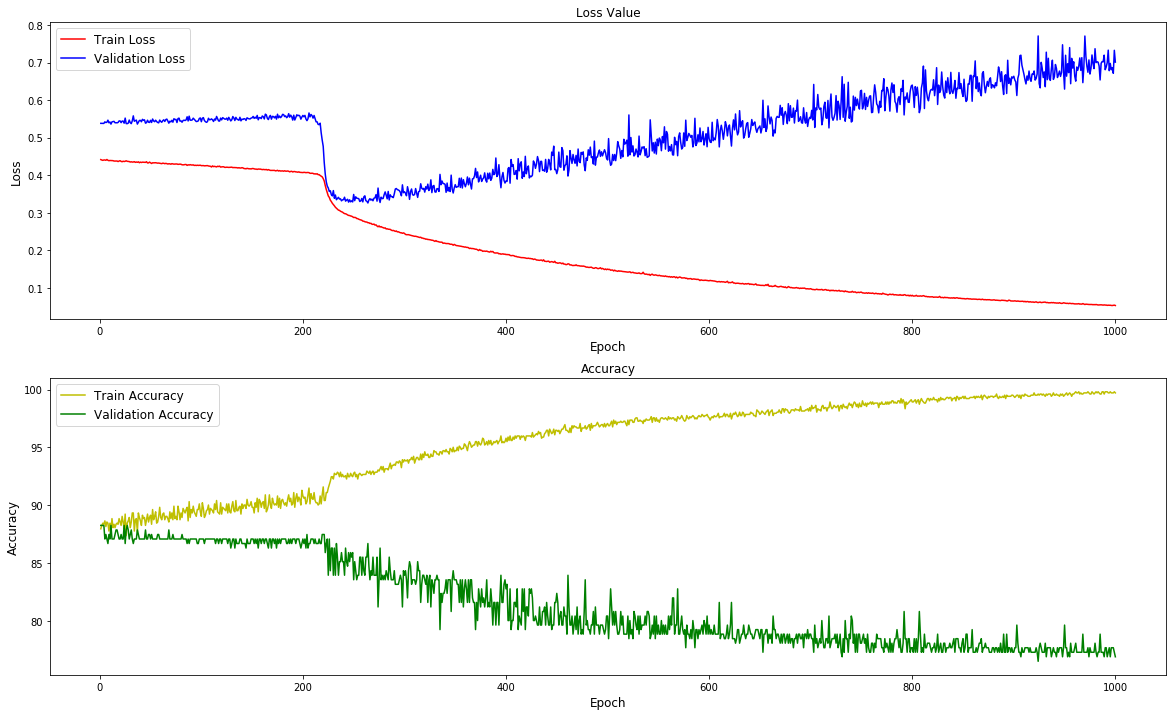

In [10]:
# PLOT TRAIN AND VALIDATION LOSS AT EVERY ITERATION
import matplotlib.pyplot as plt

fig, ax2 = plt.subplots(2,1,figsize=(20,12))
ax2[0].set_title("Loss Value")
ax2[0].set_ylabel("Loss", fontsize="12")
ax2[0].set_xlabel("Epoch", fontsize="12")
ax2[0].plot(range(1, len(loss_train_mean)+1), loss_train_mean,'-r', label='Train Loss')
ax2[0].plot(range(1, len(loss_test)+1), loss_test, '-b', label='Validation Loss')
ax2[0].legend(fontsize="12")

# PLOT TRAIN AND VALIDATION ACCURACY AT EVERY ITERATION
ax2[1].set_title("Accuracy")
ax2[1].set_ylabel("Accuracy", fontsize="12")
ax2[1].set_xlabel("Epoch", fontsize="12")
ax2[1].plot(range(1, len(accuracy_train)+1), accuracy_train, '-y', label='Train Accuracy')
ax2[1].plot(range(1, len(accuracy_test)+1), accuracy_test, '-g', label='Validation Accuracy')
ax2[1].legend(fontsize="12")
plt.show()

| dataset | loss | accuracy |
| :-- | -- | -- |
| train | {{ loss_train_mean[-1] }} | {{ accuracy_train[-1] }} |
| validation | {{ loss_test[-1] }} | {{ accuracy_test[-1] }} |